## Import section

In [1]:
!pip install tabulate > /dev/null

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from tabulate import tabulate

# Data preparation and toolbox

In [3]:
# toolbox
def set_percentage_of_values_to_nan(df, percentage):
    return df.mask(np.random.random(df.shape) < percentage)
def show_nan_percentage(df):
    print(df.isnull().sum() * 100 / len(df))
def hist_of_selected_column(df, column_name):
    hs = df[column_name]
    plt.hist(hs)
    plt.xlabel(column_name)
    plt.show()
def plot_of_two_columns(df, f_c, s_c):
    plt.plot(f_c,s_c, 'b.', data=df)
    plt.xlabel(f_c)
    plt.ylabel(s_c)
    plt.show()

In [4]:
df = pd.read_csv("./data/Olympic-atheletes.csv", sep=";")
df = df.drop(columns = 'ID')
df = df.drop_duplicates(subset="Name")

df['Height'] = set_percentage_of_values_to_nan(df['Height'], 0.05)
df['Weight'] = set_percentage_of_values_to_nan(df['Weight'], 0.05)
man_df = df[df['Sex'] == 'M']
woman_df = df[df['Sex'] == 'F']
disciplines = df['Sport'].unique()
man_players_by_discipline = {}
woman_players_by_discipline = {}
for d in disciplines:
    man_players_by_discipline[d] = man_df[man_df['Sport'] == d]
    woman_players_by_discipline[d] = woman_df[woman_df['Sport'] == d]

model = LinearRegression()

## Choose sport disciplines with given lenght

In [5]:
d_list = disciplines.tolist()
to_delete = []
for d in d_list:
    if len(man_players_by_discipline[d]) < 300:
        to_delete.append(d)
for d in to_delete:
    d_list.remove(d)

disciplines = np.array(d_list)
print(disciplines)

['Athletics' 'Rowing' 'Cycling' 'Swimming']


### Print NaN percentage

In [6]:
d_list = disciplines.tolist()
for d in d_list:
    show_nan_percentage(man_players_by_discipline[d])

Name       0.000000
Sex        0.000000
Age        0.000000
Height    10.726351
Weight     8.699324
Team       0.000000
NOC        0.000000
Sport      0.000000
dtype: float64
Name      0.000000
Sex       0.000000
Age       0.000000
Height    5.438066
Weight    6.646526
Team      0.000000
NOC       0.000000
Sport     0.000000
dtype: float64
Name      0.000000
Sex       0.000000
Age       0.000000
Height    6.542056
Weight    5.295950
Team      0.000000
NOC       0.000000
Sport     0.000000
dtype: float64
Name      0.000000
Sex       0.000000
Age       0.000000
Height    7.738095
Weight    6.150794
Team      0.000000
NOC       0.000000
Sport     0.000000
dtype: float64


## Regression for different sports

            Height       Weight
count  1005.000000  1005.000000
mean    180.853731    74.632836
std       9.199293    18.212871
min     151.000000    47.000000
25%     175.000000    62.000000
50%     180.000000    70.000000
75%     187.000000    80.000000
max     208.000000   165.000000
Drop NaN : coefficients: [[0.83853539]]
            Height       Weight
count  1184.000000  1184.000000
mean    180.873226   180.873226
std       8.677514     8.677514
min     151.000000   151.000000
25%     175.000000   175.000000
50%     180.873226   180.873226
75%     186.250000   186.250000
max     208.000000   208.000000
Mean Imputation : coefficients: [[0.90115729]]
            Height       Weight
count  1184.000000  1184.000000
mean    181.052365    74.674409
std       8.954241    17.664772
min     151.000000    47.000000
25%     175.000000    63.000000
50%     181.000000    71.000000
75%     187.000000    80.000000
max     208.000000   165.000000
Interpolation imputation : coefficients: [[0.8258

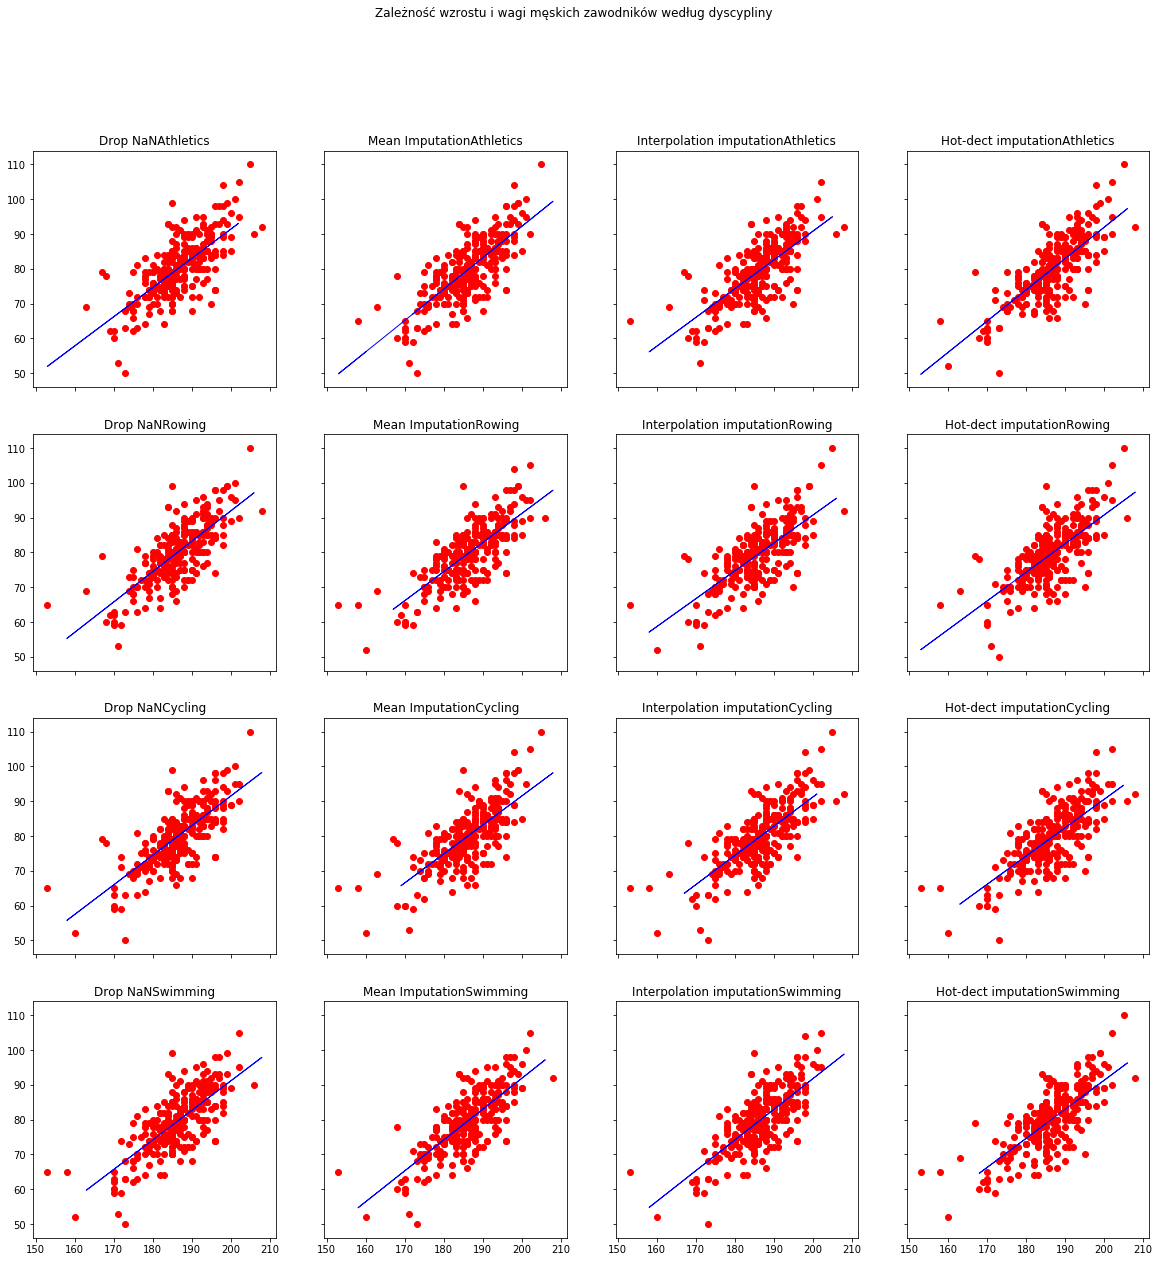

In [14]:
imputators = [
    (None, "Drop NaN"),
    (lambda dataset: SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(xs_mean), "Mean Imputation"),
    (lambda dataset: pd.DataFrame(data=dataset).interpolate().to_numpy(), "Interpolation imputation"),
    (lambda dataset: pd.DataFrame(data=dataset).fillna(method='ffill').to_numpy(), "Hot-dect imputation")
]
f, axarr = plt.subplots(len(disciplines),len(imputators), sharex=True, sharey=True,figsize=(20,20))
f.suptitle('Zależność wzrostu i wagi męskich zawodników według dyscypliny')
for i in range(0,len(disciplines)):
    for j, (imputer, title) in enumerate(imputators):
        regression_set = man_players_by_discipline[disciplines[i]][['Height', 'Weight']]
        if imputer == None:
            regression_set = regression_set.dropna()
            xs_mean = regression_set['Height'].to_numpy().reshape((-1,1))
            ys_mean = regression_set['Weight'].to_numpy().reshape((-1,1))
        if imputer != None:
            xs_mean = regression_set['Height'].to_numpy().reshape((-1,1))
            ys_mean = regression_set['Weight'].to_numpy().reshape((-1,1))
            xs_mean = imputer(xs_mean)
            ys_mean = imputer(ys_mean)
        
        x_train,x_test,y_train,y_test=train_test_split(xs,ys,test_size=0.4)
        model.fit(x_train,y_train)
        y_test = model.predict(x_test)
        result_df = pd.DataFrame({
            'Height': xs_mean[:,0],
            'Weight' : ys_mean[:,0]
        })
        print(result_df.describe())
        print(title, ': coefficients:', model.coef_)
        t_title = title + disciplines[i] 
        axarr[i,j].set_title(t_title)
        axarr[i,j].scatter(x_train, y_train, color="red")
        axarr[i,j].plot(x_test, y_test, color="blue", linewidth=1)
    print("\n\n")